# Proyecto 3 - G3 - ML

Introducción.....

## 0. Libraries

In [3]:
import os
import glob

import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn import preprocessing

#temp
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap

np.random.seed(2024)

## 1. Video Features Extracion

Para la extracción de features se usó la librería **Video Features**. No se escogió **Gluon** porque no ha tenido mantenimiento desde hace más de 1 año. 

Modelos disponibles: 

- S3D (Kinetics 400)
- R(2+1)d RGB (IG-65M, Kinetics 400):
    - r2plus1d_18_16_kinetics
    - r2plus1d_34_32_ig65m_ft_kinetics *
    - r2plus1d_34_8_ig65m_ft_kinetics
- I3D-Net RGB + Flow (Kinetics 400)

Al final obtuvimos un conjunto de .npy, los cuales leeremos y 

El comando usado fue el siguiente:

```bash
# para usar con cpu agregar argumento
python .... device="cpu"

# i3d
python main.py feature_type=i3d file_with_video_paths="../data/train_subset/video_paths.txt" on_extraction=save_numpy output_path="../data/train_output"

# s3d
python main.py feature_type=s3d file_with_video_paths="../data/train_subset/video_paths.txt" on_extraction=save_numpy output_path="../data/train_output"

# r2plus1d_18_16_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_18_16_kinetics" on_extraction=save_numpy output_path="../data/train_output"

# r2plus1d_34_32_ig65m_ft_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_34_32_ig65m_ft_kinetics" on_extraction=save_numpy output_path="../data/train_output"

# r2plus1d_34_8_ig65m_ft_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_34_8_ig65m_ft_kinetics" on_extraction=save_numpy output_path="../data/train_output"
```

In [ ]:
def split_files_to_groups(directory, num_groups=5):
    
    # Lista de los .mp4
    mp4_files = [f for f in os.listdir(directory) if f.endswith('.mp4')]
    # Concatenar path
    mp4_paths = [os.path.join(directory, f) for f in mp4_files]
    # Shuffle
    np.random.shuffle(mp4_paths)

    # Dividir en grupos
    groups = [[] for _ in range(num_groups)]
    for i, path in enumerate(mp4_paths):
        groups[i % num_groups].append(path)

    # Escribir
    for i, group in enumerate(groups):
        with open(f'group_{i+1}.txt', 'w') as file:
            for path in group:
                file.write(f"{path}\n")
                
directory = 'C:\\Users\\Adrian Cespedes\\Desktop\\utec2024_1\\ml_temp\\Proy3-ML\\data\\temp'
split_files_to_groups(directory)

# 2. Load & Save Feature Vectors

In [21]:
def aggregate_features(feature_matrix):
    mean_features = np.mean(feature_matrix, axis=0)
    std_features = np.std(feature_matrix, axis=0)
    min_features = np.min(feature_matrix, axis=0)
    max_features = np.max(feature_matrix, axis=0)
    median_features = np.median(feature_matrix, axis=0)
    
    return np.concatenate([mean_features, std_features, min_features, max_features, median_features])

In [5]:
def extract_video_data(video_features_path, labels_df):
    video_features = []
    video_labels = []
    video_empty_frames = 0
    
    for each_video in glob.glob(os.path.join(video_features_path, '*.npy')):
        youtube_id = os.path.basename(each_video).split('_')[0]
        current_video_feature = np.load(each_video)

        if current_video_feature.size == 0:
            video_empty_frames += 1
            continue

        # aggregated_features = aggregate_features(current_video_feature)
        current_video_feature_avg = np.mean(current_video_feature, axis = 0)
        # current_video_feature_avg = np.concatenate([current_video_feature_avg, aggregated_features])
        video_features.append(current_video_feature_avg)

        current_video_label = labels_df[labels_df['youtube_id'] == youtube_id]['label'].values[0]
        video_labels.append(current_video_label)

    print(f'Número de videos vacíos no agregados ({video_features_path}): {video_empty_frames}')    
    
    video_features_stacked = np.vstack(video_features)
    video_labels_stacked = np.vstack(video_labels)
    
    df_features = pd.DataFrame(video_features_stacked)
    df_labels = pd.DataFrame(video_labels_stacked)

    return df_features, df_labels

df_train_labels = pd.read_csv('./data/train_subset.csv', header = None, names = ['youtube_id', 'label'])
df_val_labels = pd.read_csv('./data/val_subset.csv', header = None, names = ['youtube_id', 'label'])

X_train, Y_train = extract_video_data('./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics', df_train_labels)
X_train.dropna(inplace = True)
Y_train.dropna(inplace = True)

print(f'\nNúmero de videos cargados para entrenamiento: {len(X_train)}')
print(f'Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}')

Número de videos vacíos no agregados (./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics): 15

Número de videos cargados para entrenamiento: 10680
Shape de nuestra matriz de videos para entrenamiento: (10680, 512)


In [6]:
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = PowerTransformer(method='yeo-johnson')
# scaler = QuantileTransformer()
normalized_data = scaler.fit_transform(X_train)

In [25]:
# lda = LDA(n_components=2)  # Queremos reducir a 2 dimensiones
# reduced_data = lda.fit_transform(normalized_data, Y_train.to_numpy().ravel())

# Reducir la dimensionalidad usando PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

# Reducir la dimensionalidad usando t-SNE
tsne = TSNE(n_components=3)
tsne_data = tsne.fit_transform(normalized_data)

# Reducir la dimensionalidad usando UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_data = umap_reducer.fit_transform(normalized_data)

# Reducir la dimensionalidad usando TriMap
trimap_reducer = trimap.TRIMAP()
trimap_data = trimap_reducer.fit_transform(normalized_data)

# Reducir la dimensionalidad usando PaCMAP
pacmap_reducer = pacmap.PaCMAP(n_neighbors=None)
pacmap_data = pacmap_reducer.fit_transform(normalized_data, init="pca")

In [8]:
le = preprocessing.LabelEncoder()
le.fit(Y_train.to_numpy().ravel())
Y_train_encoded = le.transform(Y_train.to_numpy().ravel())

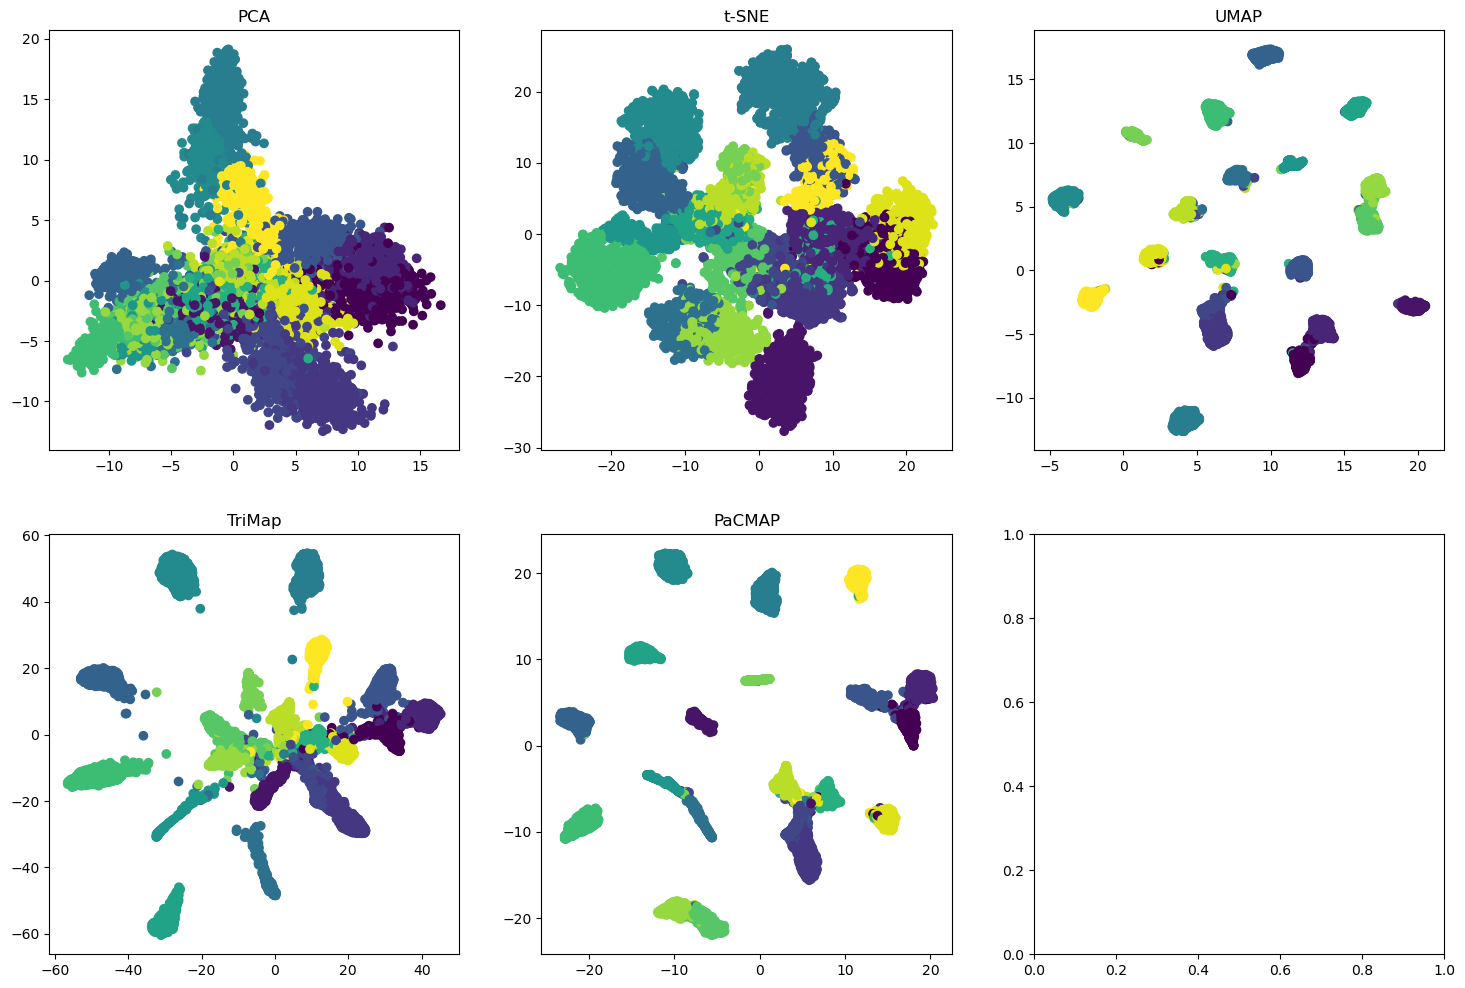

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[0][0].scatter(pca_data[:, 0], pca_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[0][0].set_title('PCA')
axs[0][1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[0][1].set_title('t-SNE')
axs[0][2].scatter(umap_data[:, 0], umap_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[0][2].set_title('UMAP')
axs[1][0].scatter(trimap_data[:, 0], trimap_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[1][0].set_title('TriMap')
axs[1][1].scatter(pacmap_data[:, 0], pacmap_data[:, 1], c=Y_train_encoded, cmap='viridis')
axs[1][1].set_title('PaCMAP')
plt.show()

In [14]:
def evaluate_clustering(reduced_data, true_labels, method_name, clustering_algorithm='kmeans'):
    if clustering_algorithm == 'kmeans':
        # Aplicar K-means para clustering en los datos reducidos
        clusterer = KMeans(n_clusters=20, random_state=2024, algorithm='lloyd')
    elif clustering_algorithm == 'meanshift':
        # Aplicar Mean Shift para clustering en los datos reducidos
        clusterer = MeanShift()
    elif clustering_algorithm == 'dbscan':
        # Aplicar DBSCAN para clustering en los datos reducidos
        clusterer = DBSCAN(eps=0.5, min_samples=4)
    elif clustering_algorithm == 'agglomerative':
        # Aplicar Agglomerative Clustering para clustering en los datos reducidos
        clusterer = AgglomerativeClustering(n_clusters=20)

    predicted_labels = clusterer.fit_predict(reduced_data)
    
    # Calcular Silhouette Score
    silhouette_avg = silhouette_score(reduced_data, predicted_labels)
    
    # Calcular Adjusted Rand Index
    ari = adjusted_rand_score(true_labels, predicted_labels)
    
    # Calcular Adjusted Mutual Information
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)

    print(f"{method_name} ({clustering_algorithm}) - Silhouette Score: {silhouette_avg:.4f}, Adjusted Rand Index: {ari:.4f}, Adjusted Mutual Information: {ami:.4f}")

In [101]:
# Evaluar clustering con PCA
evaluate_clustering(pca_data, Y_train_encoded, "PCA", clustering_algorithm='kmeans')
evaluate_clustering(pca_data, Y_train_encoded, "PCA", clustering_algorithm='dbscan')

PCA (kmeans) - Silhouette Score: 0.4354, Adjusted Rand Index: 0.5249, Adjusted Mutual Information: 0.6984
PCA (dbscan) - Silhouette Score: 0.0165, Adjusted Rand Index: 0.1619, Adjusted Mutual Information: 0.5187


In [ ]:
# Evaluar clustering con t-SNE
evaluate_clustering(tsne_data, Y_train_encoded, "t-SNE", clustering_algorithm='kmeans')
evaluate_clustering(tsne_data, Y_train_encoded, "t-SNE", clustering_algorithm='dbscan')

In [28]:
# Evaluar clustering con UMAP
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='kmeans')
# evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='meanshift')
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='dbscan')
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='agglomerative')

UMAP (kmeans) - Silhouette Score: 0.7939, Adjusted Rand Index: 0.8963, Adjusted Mutual Information: 0.9419
UMAP (dbscan) - Silhouette Score: 0.8133, Adjusted Rand Index: 0.8140, Adjusted Mutual Information: 0.9260
UMAP (agglomerative) - Silhouette Score: 0.8078, Adjusted Rand Index: 0.9439, Adjusted Mutual Information: 0.9505


In [20]:
# Evaluar clustering con TriMap
evaluate_clustering(trimap_data, Y_train_encoded, "TriMap", clustering_algorithm='kmeans')
# evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='meanshift')
evaluate_clustering(trimap_data, Y_train_encoded, "TriMap", clustering_algorithm='dbscan')
evaluate_clustering(trimap_data, Y_train_encoded, "TriMap", clustering_algorithm='agglomerative')

TriMap (kmeans) - Silhouette Score: 0.6958, Adjusted Rand Index: 0.8701, Adjusted Mutual Information: 0.9227
TriMap (dbscan) - Silhouette Score: 0.1001, Adjusted Rand Index: 0.7589, Adjusted Mutual Information: 0.8480
TriMap (agglomerative) - Silhouette Score: 0.7164, Adjusted Rand Index: 0.9148, Adjusted Mutual Information: 0.9375


In [27]:
# Evaluar clustering con PaCMAP
evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='kmeans')
# evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='meanshift')
evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='dbscan')
evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='agglomerative')

PaCMAP (kmeans) - Silhouette Score: 0.7473, Adjusted Rand Index: 0.9304, Adjusted Mutual Information: 0.9444
PaCMAP (dbscan) - Silhouette Score: 0.7098, Adjusted Rand Index: 0.6623, Adjusted Mutual Information: 0.8829
PaCMAP (agglomerative) - Silhouette Score: 0.7456, Adjusted Rand Index: 0.9255, Adjusted Mutual Information: 0.9429
